## **IMPORT**

In [5]:
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

def find_move_benchmark_all(fen: str, search_depth: int, versions: dict[int, str], plot_moves: bool = True):
    result_df = pd.DataFrame()

    num_versions = len(versions)
    cols = math.ceil(math.sqrt(num_versions))
    rows = math.ceil(num_versions / cols)

    if plot_moves:
        fig, axs = plt.subplots(rows, cols, figsize = (8 * cols, 8 * rows), squeeze = False)

    row, col = 0, 0

    for version, version_name in versions.items():
        game = ChessGame(fen)
        start = time.time()
        move, score = find_move(game, search_depth, version=version)
        end = time.time()

        result_df = result_df.append({
            'Version'         : version,
            'Version name'    : version_name,
            'Search depth'    : search_depth,
            'Execution time'  : end - start,
            'No. Evaluations' : get_evaluation_count()
        }, ignore_index = True)

        moves = None if move is None else [move]

        if plot_moves:
            axs[row, col].set_title(version_name, fontdict={'fontsize': 20, 'fontweight': 'medium'})
            game.plot(moves=moves, ax=axs[row, col])
        
        col += 1
        if col >= cols:
            col = 0
            row += 1

    while plot_moves and row < rows:
        (axs[row, col]).set_visible(False)
        col += 1
        if col >= cols:
            col = 0
            row += 1

    return result_df

def find_move_benchmark_all_multiple_depth(fen: str, start_search_depth: int, versions: dict[int, str], time_threshold: float = 1000.0):
    result_df = pd.DataFrame()

    time_threshold /= 10.0
    while len(versions) > 0:
        print(f'Evaluating {len(versions)} version(s) (search depth: {start_search_depth})')

        current_depth_result_df = find_move_benchmark_all(fen, start_search_depth, versions, plot_moves = False)
        result_df = pd.concat([result_df, current_depth_result_df], ignore_index = True)
        
        good_versions = current_depth_result_df[current_depth_result_df['Execution time'] <= time_threshold]['Version'].to_list()
        new_versions = {}
        for good_version in good_versions:
            new_versions[good_version] = versions[good_version]
        versions = new_versions

        start_search_depth += 1

    return result_df

## **TESTS**

In [6]:
versions = {
         0: 'Sequential',
         1: 'Sequential + Alpha-beta',
         2: 'Sequential + Alpha-beta + Move sorting',
         3: 'Parallel v1',
         4: 'Parallel v1 + Alpha-beta',
         5: 'Parallel v1 + Alpha-beta + Move sorting',
         6: 'Parallel v2',
         7: 'Parallel v2 + Alpha-beta',
         8: 'Parallel v2 + Alpha-beta + Move sorting',
    }

In [3]:
result = find_move_benchmark_all_multiple_depth('r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1', 2, versions)
result

Evaluating 9 version(s) (search depth: 2)
Evaluating 9 version(s) (search depth: 3)
Evaluating 9 version(s) (search depth: 4)
Evaluating 7 version(s) (search depth: 5)
Evaluating 7 version(s) (search depth: 6)
Evaluating 3 version(s) (search depth: 7)
Evaluating 1 version(s) (search depth: 8)
Evaluating 1 version(s) (search depth: 9)


,Version,Version name,Search depth,Execution time,No. Evaluations
0,0,Sequential,2,0.214383,1781
1,1,Sequential + Alpha-beta,2,0.042934,309
2,2,Sequential + Alpha-beta + Move sorting,2,0.021042,118
3,3,Parallel v1,2,0.077959,1781
4,4,Parallel v1 + Alpha-beta,2,0.079589,1781
5,5,Parallel v1 + Alpha-beta + Move sorting,2,0.081901,1781
6,6,Parallel v2,2,0.015183,1781
7,7,Parallel v2 + Alpha-beta,2,0.014300,1040
8,8,Parallel v2 + Alpha-beta + Move sorting,2,0.008998,118
9,0,Sequential,3,7.391370,61320


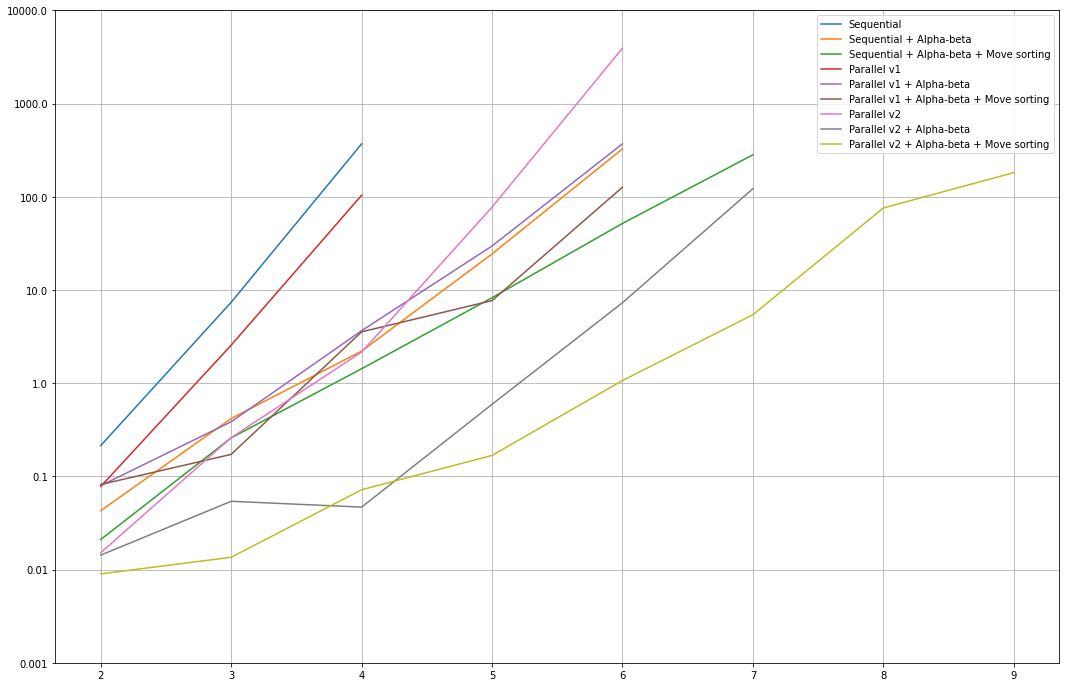

In [21]:
plt.figure(figsize = (18, 12))

colors = [
    '#032657', '#104ea3', '#3b8bf7',
    '#5e0606', '#b81d1d', '#fa5555',
    '#0b421d', '#1e8540', '#49d677'
]

for version, version_name in versions.items():
    df = result[result['Version'] == version]
    plt.plot(df['Search depth'], np.log10(df['Execution time']), label = version_name, color = colors[version])

locs, labels = plt.yticks()
plt.yticks(locs, np.power(10.0, locs))

plt.legend()
plt.grid()
plt.show()